# Projekt 1 SVHN

### Importieren der Datensätze

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision as tv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms 
import torch.nn as nn
import csv



#Load the data used for training
training_data = datasets.SVHN(
    root='/data/torchvision',
    split='train',
    transform=transforms.ToTensor(),
)

#Load the data used for testing
test_data = datasets.SVHN(
    root='/data/torchvision',
    split='test',
    transform=transforms.ToTensor(),
)

#define the batch size
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

### Konvertierung der Bilder

0
torch.Size([1, 32, 32])


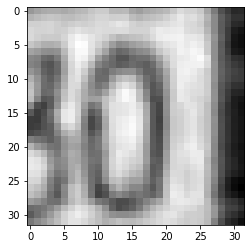

In [2]:
train_data_gray = []

for dataset in training_data:
    tensorimg, label = dataset
    
    #img = np.array(tensorimg).transpose((1,2,0))
    
    grayimage = tv.transforms.functional.rgb_to_grayscale(tensorimg, 1)
    train_data_gray.append((grayimage, label))
    
entry = train_data_gray
img = np.array(entry[2000][0]).transpose((1,2,0))
plt.imshow(img, cmap='gray')
print(entry[2000][1])
print(entry[2000][0].shape)
    

### Erste Schicht

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu1(out)
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        return out
    
model = LeNet().to(device)


print(model)

Using cuda device
LeNet(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu1): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
learningrate = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)

In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    #print(correct)
    return correct

In [17]:
epochs = 10
values = {}

def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()


learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

for idx, learningrate in enumerate(learning_rates):
    values[learningrate] = []
    model.apply(fn=weight_reset)
    optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    
    print(f"Evaluating with LR {learningrate}")
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        acc = test(test_dataloader, model, loss_fn)
        values[learningrate].append(acc)
        print(f"\tEpoch {t+1}: {acc*100}%\n-------------------------------")
    
    
print(values)
with open('learningrates.csv', 'w', newline='') as csvfile:
    fieldnames = ['learning_rate']
    for e in range(epochs):
        fieldnames.append(f"Epoche {e+1}")
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for entry in values.keys():
        entryobj = {}
        entryobj["learning_rate"] = entry;
        for e in range(epochs):
            entryobj[f"Epoche {e+1}"] = values[entry][e]
            
        writer.writerow(entryobj)




Evaluating with LR 0.01
	Epoch 1: 19.587430854333128%
-------------------------------
	Epoch 2: 19.587430854333128%
-------------------------------
	Epoch 3: 19.59895513214505%
-------------------------------
	Epoch 4: 22.59142593730793%
-------------------------------
	Epoch 5: 45.98955132145052%
-------------------------------
	Epoch 6: 67.53995082974801%
-------------------------------
	Epoch 7: 75.90657652120467%
-------------------------------
	Epoch 8: 78.34972341733251%
-------------------------------
	Epoch 9: 79.790258143823%
-------------------------------
	Epoch 10: 81.0617701290719%
-------------------------------
Evaluating with LR 0.05
	Epoch 1: 19.587430854333128%
-------------------------------
	Epoch 2: 73.43269821757836%
-------------------------------
	Epoch 3: 78.16533497234174%
-------------------------------
	Epoch 4: 83.0938844499078%
-------------------------------
	Epoch 5: 85.39489858635525%
-------------------------------
	Epoch 6: 86.46281499692687%
--------